In [286]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

In [287]:
## Fonctions to plot

def col_target_q(col, data):
    group_target = data.groupby(['target'])[col].value_counts().reset_index()
    group_target.rename(columns={0:'nbr'}, inplace=True)
    f, ax = plt.subplots(figsize=(15, 4))
    sns.barplot(x=col, y='nbr', hue='target', data=group_target.sort_values(col), hue_order=[0,1])
    
def col_target(col, data):
    group_target = data.groupby(['target'])[col].value_counts()
    state_pcts = group_target.groupby(level=1).apply(lambda x: 100*x/float(x.sum()))
    lol = pd.DataFrame(state_pcts)
    lol.reset_index(inplace=True)
    lol.rename(columns={0:'nbr'}, inplace=True)
    f, ax = plt.subplots(figsize=(15, 4))
    sns.barplot(x=col, y='nbr', hue='target', data=lol.sort_values(col), hue_order=[0,1])

In [288]:
data = pd.read_csv('../data/data.csv', encoding='utf-8')

In [289]:
data.shape

(962, 126)

In [290]:
data.target.value_counts(normalize=True)

1.0    0.878378
0.0    0.121622
Name: target, dtype: float64

## Analyse sur le sexe parrain / filleul

In [291]:
# Parrain
data["H/F"].head()

0    F
1    H
2    F
3    F
4    H
Name: H/F, dtype: object

In [292]:
# Filleul
data["Sexe"].head()

0    F
1    H
2    H
3    F
4    H
Name: Sexe, dtype: object

In [293]:
data["sexe_egal"] = data.apply(lambda row: 1 if row["H/F"] == row["Sexe"] else 0, axis=1)

In [294]:
data.sexe_egal.value_counts()

1    555
0    407
Name: sexe_egal, dtype: int64

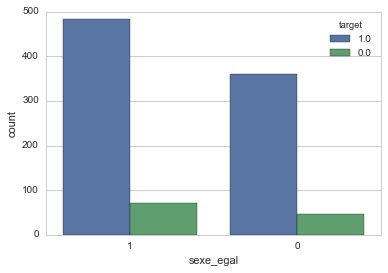

In [295]:
sns.countplot(x='sexe_egal', data=data, hue='target')

## Analyse même ville parrain / filleul (résidence)

Ne pas prendre

In [296]:
# Parrain 
data["Code postal actuel"].head()

0    75010
1    75116
2    93100
3    92400
4    75017
Name: Code postal actuel, dtype: object

In [297]:
# filleul
data["Code postal"].head()

0    51100
1    95260
2    95260
3    69100
4    75010
Name: Code postal, dtype: object

In [298]:
data["code_postal_residence_egal"] = data.apply(lambda row: 1 if row["Code postal actuel"] == row["Code postal"] else 0, axis=1)

In [299]:
data["code_postal_residence_egal"].value_counts()

0    953
1      9
Name: code_postal_residence_egal, dtype: int64

## Analyse même ville parrain / filleul (école)

Ne pas prendre

In [300]:
# filleul
data[u"Code postal de l'établissement actuel"].head()

0    51100
1    95000
2    78351
3    69001
4    75000
Name: Code postal de l'établissement actuel, dtype: object

In [301]:
data["code_postal_residence_egal"] = data.apply(lambda row: 1 if row["Code postal actuel"] == row[u"Code postal de l'établissement actuel"] else 0, axis=1)

In [302]:
data["code_postal_residence_egal"].value_counts()

0    950
1     12
Name: code_postal_residence_egal, dtype: int64

## Analyse Age parrain / filleul

In [303]:
# Parrain :
data["annee_naissance_p"] = pd.to_datetime(data["Date de naissance_p"], errors='coerce').dt.year

In [304]:
# Filleul :
data["annee_naissance_f"] = pd.to_datetime(data["Date de naissance_f"], errors='coerce').dt.year

In [305]:
data["annee_naissance_f"].head()

0    1996
1    1991
2    1993
3    1997
4    1994
Name: annee_naissance_f, dtype: int64

In [306]:
data['diff_annee_naissance'] = data["annee_naissance_f"] - data["annee_naissance_p"]

In [307]:
data['diff_annee_naissance'].describe()

count    779.000000
mean      14.178434
std       10.798231
min      -22.000000
25%        9.000000
50%       12.000000
75%       17.000000
max       92.000000
Name: diff_annee_naissance, dtype: float64

In [308]:
data[["Date de naissance_p", "annee_naissance_f"]][data['diff_annee_naissance'] == -22.0]

,Date de naissance_p,annee_naissance_f
472,2013-11-25 00:00:00,1991


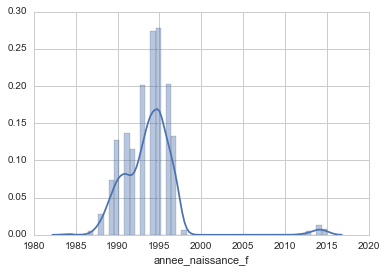

In [309]:
sns.distplot(data.annee_naissance_f)

## Age du Filleul

In [310]:
import datetime

In [312]:
today = datetime.date.today()
#data['age_f'] = ((pd.to_datetime(data["Date de naissance_f"], errors='coerce') - pd.datetime.now()) \
#                 / np.timedelta64(1, 'D')).astype(int)

data['age_f'] = pd.datetime.now().year - pd.to_datetime(data["Date de naissance_f"], errors='coerce').dt.year

In [313]:
data['age_f'].head()

0    20
1    25
2    23
3    19
4    22
Name: age_f, dtype: int64

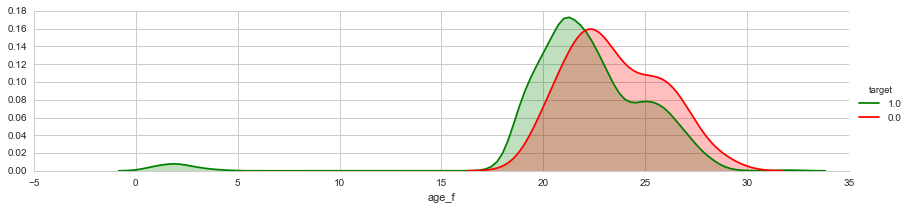

In [314]:
pal = ["g", "r"]
facet = sns.FacetGrid(data, hue="target",aspect=4, palette=pal)
facet.map(sns.kdeplot,'age_f',shade= True)
facet.add_legend()

### Detect outliers Filleuls

In [933]:
# Some outlier with 1 or 2 years old
len(data.age_f[data.age_f <= data.age_f.mean() - 3*(data.age_f.std())])

0

In [932]:
data.loc[data['age_f'] >= (data['age_f'].mean() + 3 * data['age_f'].std()), 'age_f'] = np.nan
data.loc[data['age_f'] <= (data['age_f'].mean() - 3 * data['age_f'].std()), 'age_f'] = np.nan

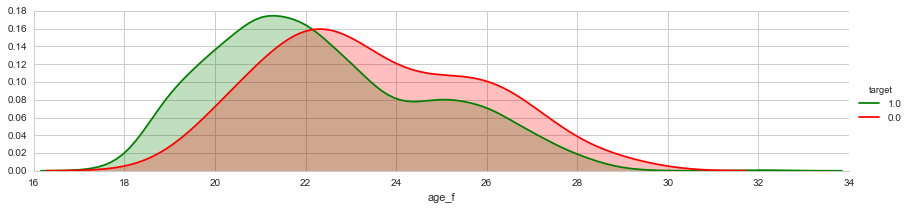

In [934]:
pal = ["g", "r"]
facet = sns.FacetGrid(data, hue="target",aspect=4, palette=pal)
facet.map(sns.kdeplot,'age_f',shade= True)
facet.add_legend()

## Age Parrain

In [625]:
from sklearn.preprocessing import Imputer
data['age_p'] = pd.datetime.now().year - pd.to_datetime(data["Date de naissance_p"], errors='coerce').dt.year
print "Imput missing value..."
# col age_p have some NaN
imp = Imputer(strategy='median', axis=1)
data["age_p"] = pd.Series(imp.fit_transform(data["age_p"])[0])

Imput missing value...


/Users/babou/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


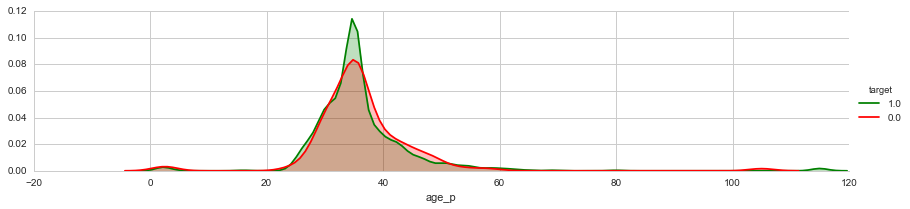

In [626]:
pal = ["g", "r"]
facet = sns.FacetGrid(data, hue="target",aspect=4, palette=pal)
facet.map(sns.kdeplot,'age_p',shade= True)
facet.add_legend()

### Detect outliers Parrains

In [741]:
len(data.age_p[data.age_p >= data.age_p.mean() + 3*(data.age_p.std())])

9

In [740]:
data.age_p[data.age_p <= data.age_p.mean() - 3*(data.age_p.std())]

40     2.0
313    2.0
378    3.0
472    3.0
482    2.0
520    2.0
587    4.0
615    2.0
618    2.0
919    2.0
Name: age_p, dtype: float64

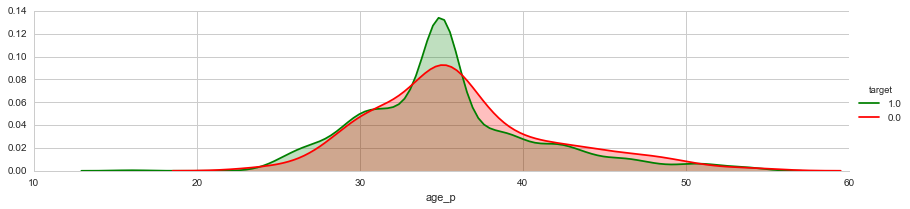

In [743]:
data.loc[data['age_p'] >= (data['age_p'].mean() + 3 * data['age_p'].std()), 'age_p'] = np.nan
data.loc[data['age_p'] <= (data['age_p'].mean() - 3 * data['age_p'].std()), 'age_p'] = np.nan

pal = ["g", "r"]
facet = sns.FacetGrid(data, hue="target",aspect=4, palette=pal)
facet.map(sns.kdeplot,'age_p',shade= True)
facet.add_legend()

## Différence d'age Parrains / Filleuls

In [935]:
data["age_diff"] = data["age_p"] - data["age_f"]

In [938]:
data.age_diff.describe()

count    910.000000
mean      12.847253
std        5.481820
min       -7.000000
25%        9.000000
50%       12.000000
75%       15.000000
max       35.000000
Name: age_diff, dtype: float64

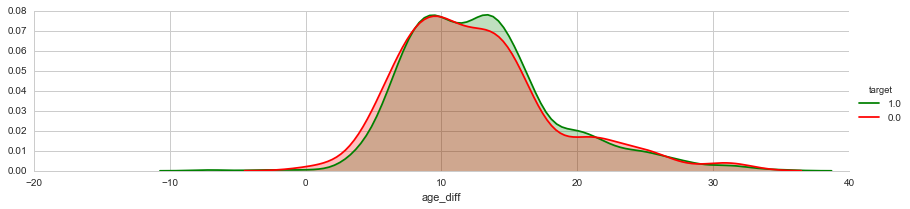

In [936]:
pal = ["g", "r"]
facet = sns.FacetGrid(data, hue="target",aspect=4, palette=pal)
facet.map(sns.kdeplot,'age_diff',shade= True)
facet.add_legend()

#### La différence d'age ne semble pas jouer sur la réussite ou l'échec d'un parainage

## Formation filleul

In [317]:
def group_formation(x):
#    try:
    if "ecole" in x.lower():
        return "ecole"
    elif "universit" in x.lower():
        return "universite"
    elif "institut" in x.lower():
        return "institut"
    else:
        return "autre"
#    except:
#        print x

In [318]:
data["group_formation_f"] = data["Formation actuelle"].apply(lambda x: group_formation(x))

In [319]:
data.group_formation_f.value_counts()

ecole         370
universite    282
autre         254
institut       56
Name: group_formation_f, dtype: int64

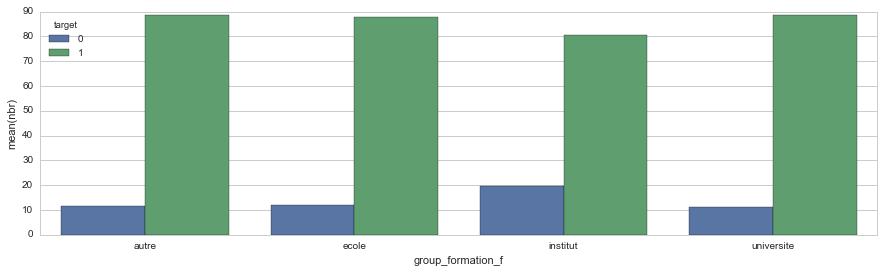

In [320]:
col_target("group_formation_f", data)

## Formation parrain

In [321]:
# Rename col
data.rename(columns={u'Dipl\xf4me Principal':'Diplome Principal'}, inplace=True)

In [322]:


data["group_formation_p"] = data["Diplome Principal"].apply(lambda x: group_formation(x))

In [323]:
data.group_formation_p.value_counts()

ecole         798
universite    162
autre           2
Name: group_formation_p, dtype: int64

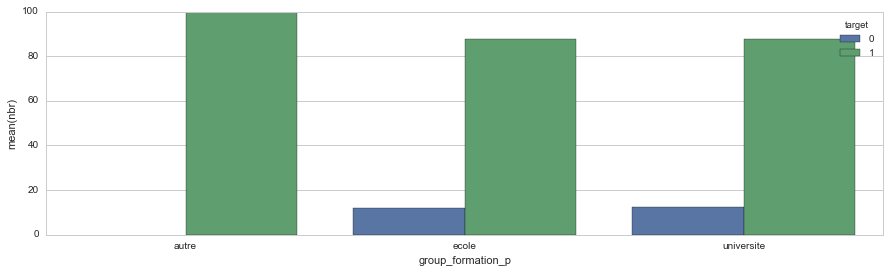

In [324]:
col_target("group_formation_p", data)

## Similitude formation parrain / filleul

In [325]:
data['formation_egal'] = data.apply(lambda row: 1 if row["group_formation_p"] == row["group_formation_f"] else 0, axis=1)

In [326]:
data['formation_egal'].value_counts()

0    497
1    465
Name: formation_egal, dtype: int64

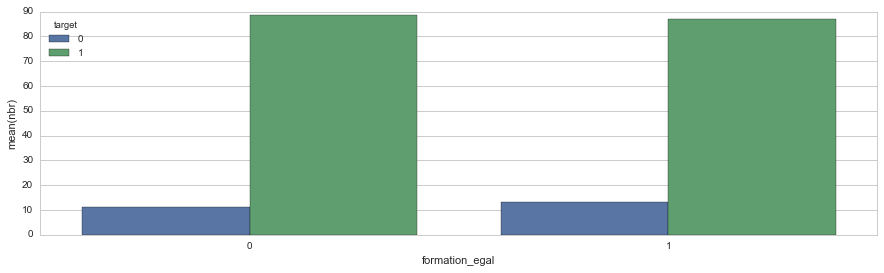

In [327]:
col_target("formation_egal", data)

## Similitude Code Formation parrain / filleul

In [328]:
data["Code formation_p"].value_counts()

3 : Commerce / Finance / Gestion                                                   384
1 : Ingénieurs / Sciences dures                                                    277
4 : Sciences politiques / Droit                                                    165
5 : Sciences humaines et Sociales (anciennement lettres, histoire, philo, arts)     64
2 : Sciences du vivant                                                              44
6 : Autres                                                                          28
Name: Code formation_p, dtype: int64

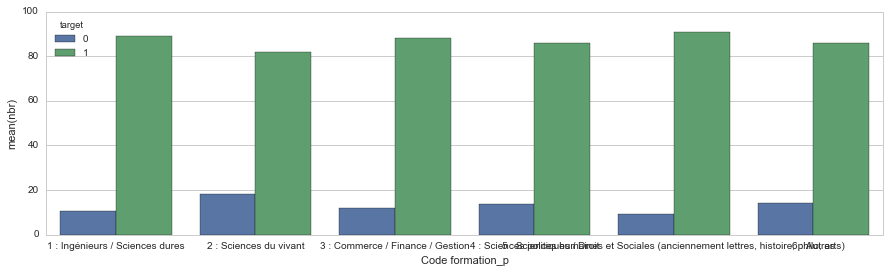

In [329]:
col_target("Code formation_p", data)

In [330]:
data["Code formation_f"].value_counts()

3 : Commerce / Finance / Gestion                                                   370
1 : Ingénieurs / Sciences dures                                                    278
4 : Sciences politiques / Droit                                                    167
5 : Sciences humaines et Sociales (anciennement lettres, histoire, philo, arts)     77
2 : Sciences du vivant                                                              46
6 : Autres                                                                          24
Name: Code formation_f, dtype: int64

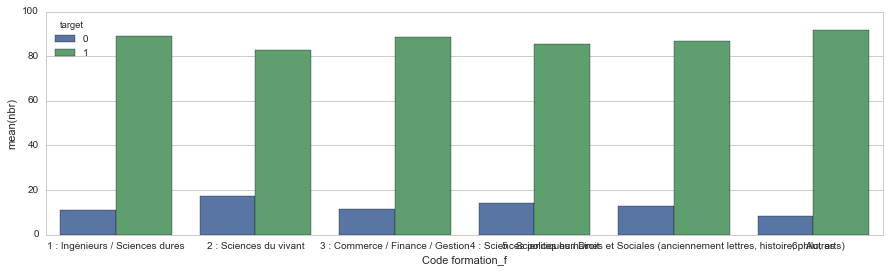

In [331]:
col_target("Code formation_f", data)

In [332]:
data["code_formation_egal"] = data.apply(lambda row: 1 if row["Code formation_f"] == row["Code formation_p"] else 0, axis=1)

In [333]:
data["code_formation_egal"].value_counts()

1    886
0     76
Name: code_formation_egal, dtype: int64

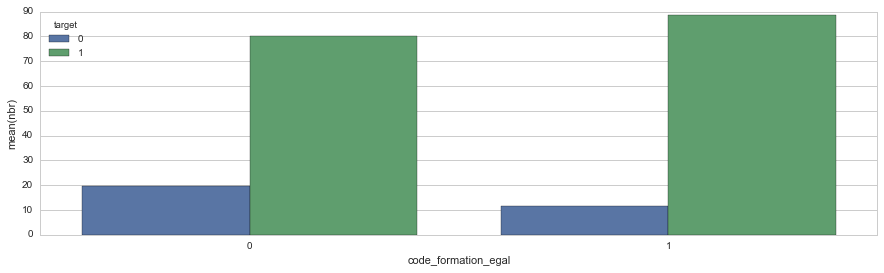

In [334]:
col_target("code_formation_egal", data)

## Analyse projet motivation filleul / activité parrain

In [335]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import TreebankWordTokenizer



import nltk.stem

In [336]:
stem = nltk.stem.snowball.FrenchStemmer(ignore_stopwords=True)

In [337]:
stop = [word for word in stopwords.words('french')]

In [338]:
def get_similitude_projet_activite(projet, activite):
    """
    projet : motivation du filleul
    activite : activité du parrain
    -----------
    Stem all word in description.
    If match with this stem description (1 word activite in projet) return 1 else 0.
    
    If projet or activite is NaN, return 0
    """
    if projet is np.nan:
        return 0
    if activite is np.nan:
        return 0
    projet_stem = [stem.stem(word) for word in word_tokenize(projet) if word not in stop]
    activite_stem = [stem.stem(word) for word in word_tokenize(activite) if word not in stop]
    
    if len(set(activite_stem).intersection(projet_stem)) >= 1:
        return 1
    else:
        return 0

In [339]:
data["projet_f_activite_p_egal"] = data.apply(lambda row: get_similitude_projet_activite(row["Projet professionnel"],
                                                                                        row[u"Secteur d'activité"]),
                                             axis=1)

In [340]:
data["projet_f_activite_p_egal"].value_counts()

0    765
1    197
Name: projet_f_activite_p_egal, dtype: int64

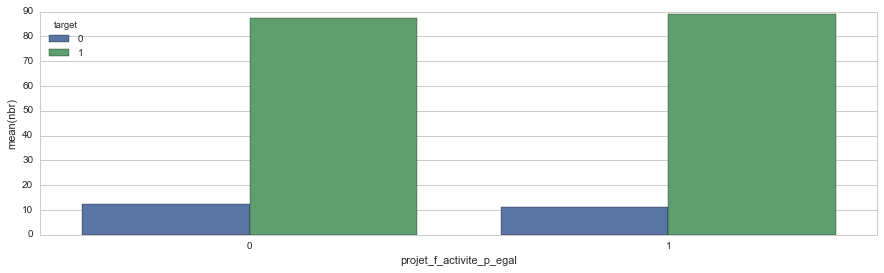

In [341]:
col_target("projet_f_activite_p_egal", data)

## Analyse projet motivation filleul / activité parrain précédente

In [344]:
data["projet_f_activite_pre_p_egal"] = data.apply(lambda row: get_similitude_projet_activite(row["Projet professionnel"],
                                                                                        row[u"Fonction précédente"]),
                                             axis=1)

In [345]:
data["projet_f_activite_pre_p_egal"].value_counts()

0    898
1     64
Name: projet_f_activite_pre_p_egal, dtype: int64

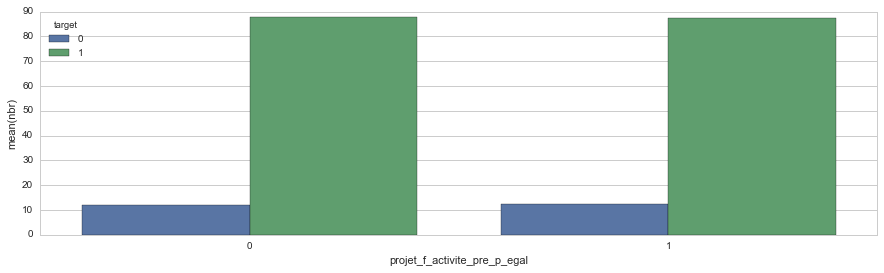

In [346]:
col_target("projet_f_activite_pre_p_egal", data)

## Analyse projet motivation filleul / activité parrain (précédent ou non)

In [347]:
data['projet_f_activite_p_egal_all'] = 0

In [348]:
data.loc[(data["projet_f_activite_p_egal"] == 1) | (data["projet_f_activite_pre_p_egal"] == 1), 'projet_f_activite_p_egal_all'] = 1

In [349]:
data.groupby(["projet_f_activite_pre_p_egal", "projet_f_activite_p_egal"]).size()

projet_f_activite_pre_p_egal  projet_f_activite_p_egal
0                             0                           717
                              1                           181
1                             0                            48
                              1                            16
dtype: int64

In [350]:
data["projet_f_activite_p_egal_all"].value_counts()

0    717
1    245
Name: projet_f_activite_p_egal_all, dtype: int64

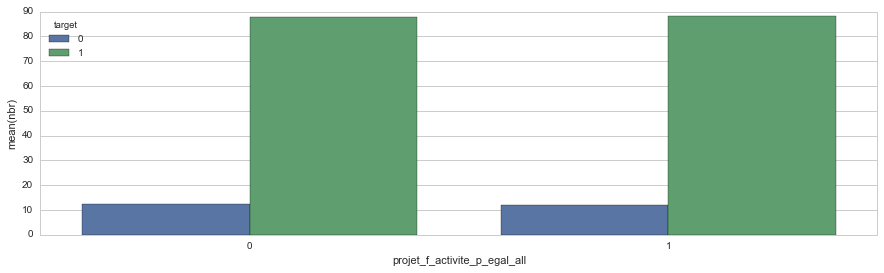

In [351]:
col_target("projet_f_activite_p_egal_all", data)

## Connaissance de Frateli (filleul)

In [352]:
data["Connaissance du programme Frateli"].value_counts()

Autre                                            236
Par un autre filleul                             162
Lors d'une visite de Frateli en terminale        155
Par l'équipe enseignante de mon établissement    106
Par la plaquette CNOUS                            98
Par le bouche à oreille                           85
Lors d'une visite de Frateli en prépa             84
Sur internet                                      36
Name: Connaissance du programme Frateli, dtype: int64

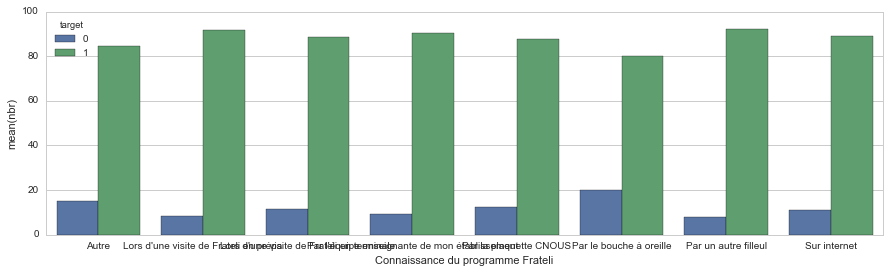

In [353]:
col_target("Connaissance du programme Frateli", data)

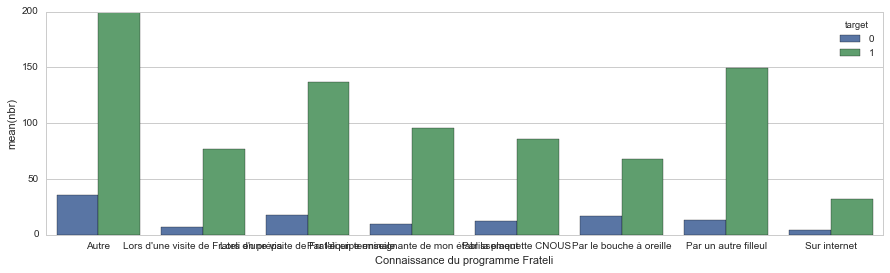

In [354]:
col_target_q("Connaissance du programme Frateli", data)

## Analyse similitude de niveau d'étude

In [355]:
# Parrain
data[u"Niveau diplôme"].value_counts()

Bac +5               811
Bac +6                45
Bac +8 et au-delà     38
Bac +4                30
Bac +7                26
Bac +3                 5
1er emploi             2
Bac +2                 1
Bac +1                 1
Name: Niveau diplôme, dtype: int64

In [356]:
# Filleul
data["Niveau"].value_counts()

Bac +3               202
Bac +2               192
Bac +4               187
Bac +1               170
Bac +5               155
Bac +6                25
1er emploi            23
Bac +7                 6
Bac +8 et au-delà      1
Terminale              1
Name: Niveau, dtype: int64

In [733]:
data["niveau_etude_egal"] = data.apply(lambda row: 1 if row[u"Niveau diplôme"] == row[u"Niveau"] else 0, axis=1)

In [734]:
data["niveau_etude_egal"].value_counts()

0    823
1    139
Name: niveau_etude_egal, dtype: int64

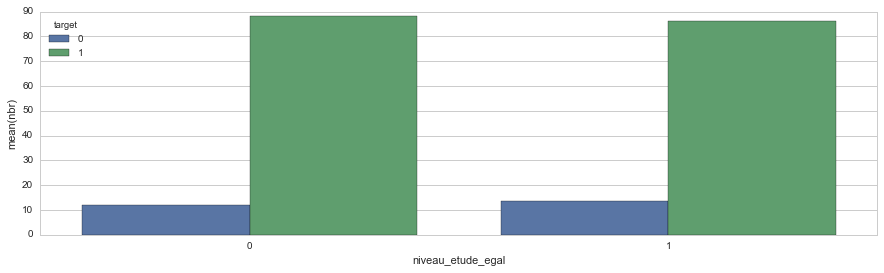

In [735]:
col_target("niveau_etude_egal", data)

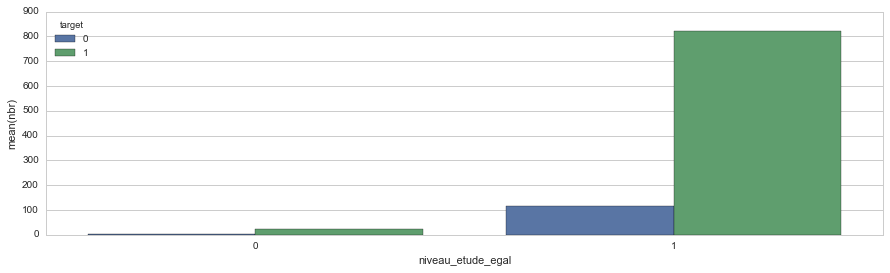

In [360]:
col_target_q("niveau_etude_egal", data)

In [ ]:
data["niveau_etude_egal"] = 

## Analyse similitude de niveau d'étude (différence)

In [361]:
map_niveau = {"Bac +3" : 3,
                "Bac +2" : 2,
                "Bac +4" : 4,
                "Bac +1" : 1,
                "Bac +5" : 5,
                "Bac +6" : 6,
                "1er emploi" : 0,
                "Bac +7" : 7,
                u"Bac +8 et au-del\xe0" : 8,
                "Terminale" : 0}

In [362]:
data["Niveau"][data.Niveau.str.contains("8")]

238    Bac +8 et au-delà
Name: Niveau, dtype: object

In [363]:
map_niveau.get(data["Niveau"].iloc[238])

8

In [364]:
# Filleul
data["Niveau_num"] = data["Niveau"].apply(lambda x: map_niveau.get(x))

In [645]:
# Parrain
data[u"Niveau_diplome_num"] = data[u"Niveau diplôme"].apply(lambda x: map_niveau.get(x, -1)) # if Nan -> -1

In [647]:
data[u"Niveau diplôme"].value_counts()

Bac +5               811
Bac +6                45
Bac +8 et au-delà     38
Bac +4                30
Bac +7                26
Bac +3                 5
1er emploi             2
Bac +2                 1
Bac +1                 1
Name: Niveau diplôme, dtype: int64

In [367]:
data["diff_niveau_etude_num"] = data["Niveau_num"] - data[u"Niveau_diplome_num"]

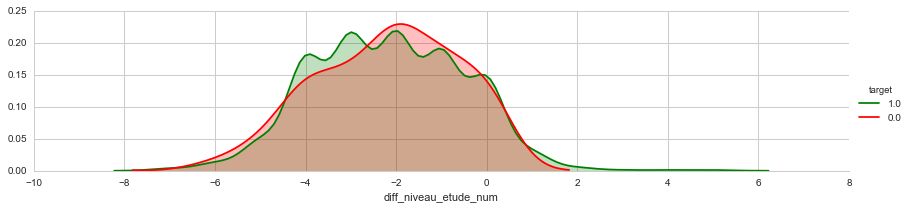

In [368]:
pal = ["g", "r"]
facet = sns.FacetGrid(data, hue="target",aspect=4, palette=pal)
facet.map(sns.kdeplot,'diff_niveau_etude_num',shade= True)
facet.add_legend()

## Bourses Filleuls

In [817]:
# Binary for bourier sup or not for "Boursier de l'enseignement supérieur"
data["boursier_sup"] = data[u"Boursier de l'enseignement supérieur"].apply(lambda x: {'Non' : 0}.get(x, 1))

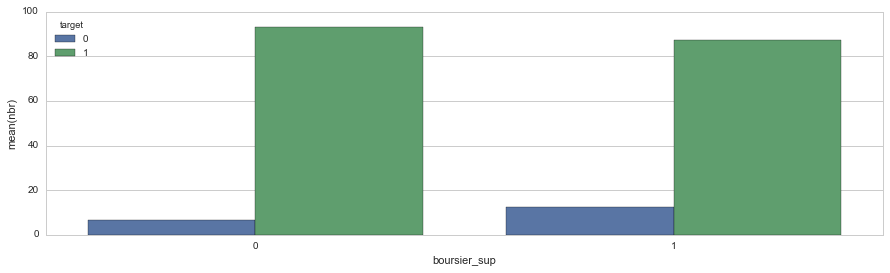

In [819]:
col_target("boursier_sup", data)

In [ ]:
# Binary for bourier sup or not for "Boursier de l'enseignement supérieur"
# There are 84 missing value. We assume if missing then "Non" (no bourse)

In [820]:
pd.isnull(data[u"Bousier de l'enseignement secondaire"]).sum()

84

In [824]:
data.loc[pd.isnull(data[u"Bousier de l'enseignement secondaire"]), u"Bousier de l'enseignement secondaire"] = "Non"

In [825]:
data[u"Bousier de l'enseignement secondaire"].value_counts()

Oui    560
Non    402
Name: Bousier de l'enseignement secondaire, dtype: int64

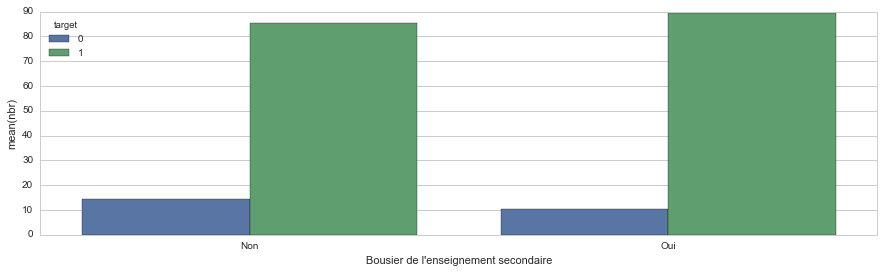

In [826]:
col_target(u"Bousier de l'enseignement secondaire", data)

## Clustering des Filleuls

In [495]:
from sklearn.preprocessing import StandardScaler, LabelEncoder

In [827]:
features_f = ["Sexe", "group_formation_f", "Niveau_num", "Code formation_f" ,
              "age_f", u"Nombre de frères et soeurs", "Type de commune", "boursier_sup",
             u"Bousier de l'enseignement secondaire"]
            # Ordinateur disponible
            # Internet disponible
            
features_f_continus = ["Niveau_num", "age_f", u"Nombre de frères et soeurs"]


In [828]:
filleul = data[features_f].copy()
filleul.head()

,Sexe,group_formation_f,Niveau_num,Code formation_f,age_f,Nombre de frères et soeurs,Type de commune,boursier_sup,Bousier de l'enseignement secondaire
0,F,autre,1,3 : Commerce / Finance / Gestion,20,4.0,Dans une petite ville (moins de 20 000 habitants),1,Oui
1,H,ecole,5,3 : Commerce / Finance / Gestion,25,4.0,Dans une petite ville (moins de 20 000 habitants),1,Non
2,H,ecole,4,3 : Commerce / Finance / Gestion,23,4.0,Dans une petite ville (moins de 20 000 habitants),1,Non
3,F,ecole,1,3 : Commerce / Finance / Gestion,19,1.0,Dans une ville moyenne (de 20 000 à 100 000 ha...,1,Oui
4,H,ecole,4,3 : Commerce / Finance / Gestion,22,2.0,"A la campagne ou dans une petite commune, près...",1,Oui


In [829]:
# If no value then "Nombre de frères et soeurs" = 0
filleul.loc[pd.isnull(filleul[u"Nombre de frères et soeurs"]), u"Nombre de frères et soeurs"] = 0

In [830]:
filleul[features_f_continus].head()

,Niveau_num,age_f,Nombre de frères et soeurs
0,1,20,4.0
1,5,25,4.0
2,4,23,4.0
3,1,19,1.0
4,4,22,2.0


In [831]:
for col_continus in features_f_continus:
    scaler = StandardScaler()
    filleul[col_continus] = scaler.fit_transform(filleul[col_continus].values)

/Users/babou/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/babou/anaconda/lib/python2.7/site-packages/sklearn/preprocessing/data.py:583: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/Users/babou/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/babou/anaconda/lib/python2.7/site-packages/sklearn/preprocessing/data.py:646: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError

In [832]:
filleul.head()

,Sexe,group_formation_f,Niveau_num,Code formation_f,age_f,Nombre de frères et soeurs,Type de commune,boursier_sup,Bousier de l'enseignement secondaire
0,F,autre,-1.308338,3 : Commerce / Finance / Gestion,-0.600508,1.067573,Dans une petite ville (moins de 20 000 habitants),1,Oui
1,H,ecole,1.312424,3 : Commerce / Finance / Gestion,0.785501,1.067573,Dans une petite ville (moins de 20 000 habitants),1,Non
2,H,ecole,0.657234,3 : Commerce / Finance / Gestion,0.231098,1.067573,Dans une petite ville (moins de 20 000 habitants),1,Non
3,F,ecole,-1.308338,3 : Commerce / Finance / Gestion,-0.877710,-0.672131,Dans une ville moyenne (de 20 000 à 100 000 ha...,1,Oui
4,H,ecole,0.657234,3 : Commerce / Finance / Gestion,-0.046104,-0.092230,"A la campagne ou dans une petite commune, près...",1,Oui


In [833]:
# Better use dummy than LabelEncoder

filleul_dummy = pd.get_dummies(filleul)

#for col in filleul.columns:
#        if filleul[col].dtype=='object':
#            print str(col) + " is encoded"
#            lbl = LabelEncoder()
#            filleul[col] = lbl.fit_transform(filleul[col].values)


In [834]:
filleul_dummy.head()
#filleul.head()

,Niveau_num,age_f,Nombre de frères et soeurs,boursier_sup,Sexe_F,Sexe_H,group_formation_f_autre,group_formation_f_ecole,group_formation_f_institut,group_formation_f_universite,...,Code formation_f_6 : Autres,Type de commune_A l'étranger,"Type de commune_A la campagne ou dans une petite commune, loin d'une ville","Type de commune_A la campagne ou dans une petite commune, près d'une ville",Type de commune_A renseigner,Type de commune_Dans une grande ville (plus de 100 000 habitants),Type de commune_Dans une petite ville (moins de 20 000 habitants),Type de commune_Dans une ville moyenne (de 20 000 à 100 000 habitants),Bousier de l'enseignement secondaire_Non,Bousier de l'enseignement secondaire_Oui
0,-1.308338,-0.600508,1.067573,1,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,1.312424,0.785501,1.067573,1,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2,0.657234,0.231098,1.067573,1,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3,-1.308338,-0.877710,-0.672131,1,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
4,0.657234,-0.046104,-0.092230,1,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [835]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans


In [919]:
pca = PCA(n_components=0.95).fit(filleul_dummy.values)
X_pca = pca.transform(filleul_dummy.values)
k_means = KMeans(init='k-means++', n_clusters=5).fit(X_pca)


In [917]:
print pca.explained_variance_ratio_
print pca.explained_variance_ratio_.sum()

[ 0.25250214  0.16700987  0.09208418  0.08837495  0.07287275  0.05466083
  0.0470762   0.0420442   0.03273407  0.02489769  0.02402035  0.02217183
  0.01934784  0.01422381]
0.95402071635


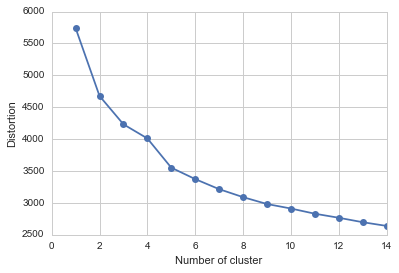

In [918]:
distortions = []
for i in range (1, 15):
    km = k_means = KMeans(init='k-means++', n_clusters=i, n_init=10).fit(X_pca)
    distortions.append(km.inertia_)
plt.plot(range(1, 15), distortions, marker='o')
plt.xlabel('Number of cluster')
plt.ylabel('Distortion')
plt.show()

#### Prendre 5 ou 6 cluster pour les filleuls

In [920]:
filleul["cluster"] = k_means.labels_
filleul["pca_1"] =  X_pca[:,0]
filleul["pca_2"] =  X_pca[:,1]
filleul["pca_3"] =  X_pca[:,2]

In [921]:
#filleul.groupby('cluster').describe()

In [922]:
k_means_labels = k_means.labels_
k_means_cluster_centers = k_means.cluster_centers_
k_means_labels_unique = np.unique(k_means_labels)

In [923]:
dico_color = {0: '#4169e1',
              1: '#4169e1',
              2: '#00ff7f',
              3: '#77dfc9',
              4: '#c2cc4a',
              5: '#ff8c00',
              6: '#ff6d00',
              7: '#ff4500',
              8: '#f1ae50',
              9: '#ffa500'
              }
#'#4169e1','#4169e1','#00ff7f','#c2cc4a','#ff8c00','#ff6d00','#ff4500'

center_color = [col for col in dico_color.values()]

color = [col for col in dico_color.values()]
filleul["color"] = filleul.cluster.map(dico_color)

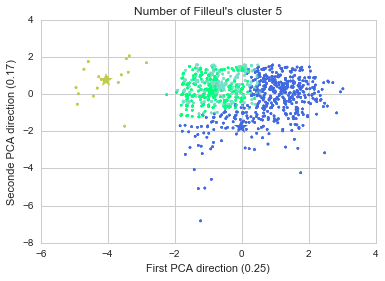

In [924]:
for k, col in zip(range(k_means_labels_unique.argmax() + 1), color):
    my_members = k_means_labels == k
    cluster_center = k_means_cluster_centers[k]
    plt.scatter(filleul.pca_1, filleul.pca_2, color=filleul.color,
             marker='.', alpha=0.6)
    plt.plot(cluster_center[0], cluster_center[1], 
         '*', markerfacecolor=col, markersize=15)
                     
plt.title("Number of Filleul's cluster %d" % k_means.n_clusters)
plt.xlabel('First PCA direction (%s)' % round(pca.explained_variance_ratio_[0], 2))
plt.ylabel('Seconde PCA direction (%s)' % round(pca.explained_variance_ratio_[1], 2))

In [925]:
filleul.cluster.value_counts()

1    347
2    266
3    196
0    136
4     17
Name: cluster, dtype: int64

In [926]:
filleul['target'] = data.target

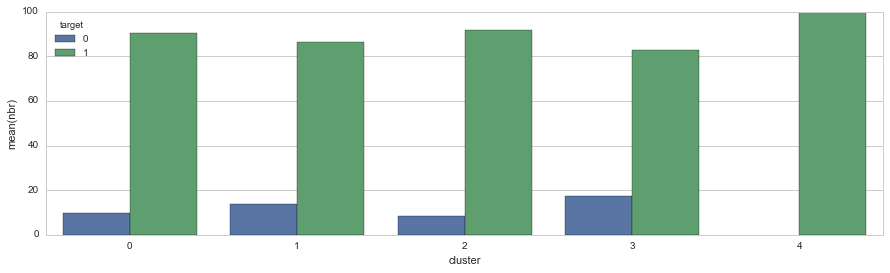

In [927]:
col_target("cluster", filleul)

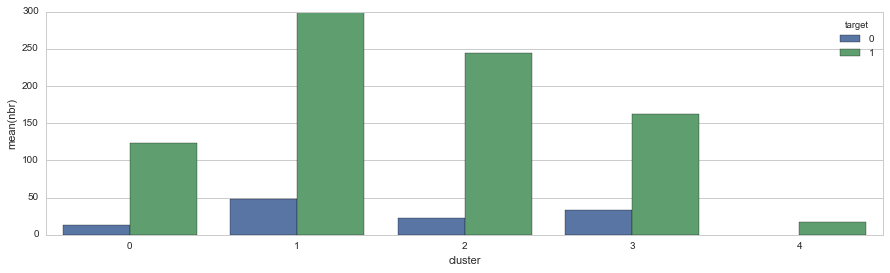

In [928]:
col_target_q("cluster", filleul)

[]

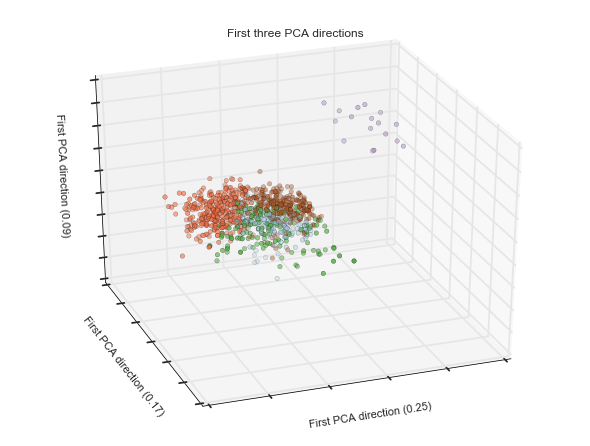

In [914]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, elev=-150, azim=110)
ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=k_means.labels_,
           cmap=plt.cm.Paired)
ax.set_title("First three PCA directions")
ax.set_xlabel('First PCA direction (%s)' % round(pca.explained_variance_ratio_[0], 2))
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel('First PCA direction (%s)' % round(pca.explained_variance_ratio_[1], 2))
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel('First PCA direction (%s)' % round(pca.explained_variance_ratio_[2], 2))
ax.w_zaxis.set_ticklabels([])


## Clustering des Parrains

In [915]:
features_p = ["H/F", "group_formation_p", "Niveau_diplome_num", "Code formation_p" ,
              "age_p", u"Secteur d'activité", "Fonction actuelle", u"A déjà eu un parrainage annulé ?",
             "Temporairement indisponible"]
            # Niveau autre formation
            
features_p_continus = ["Niveau_diplome_num", "age_p"]

In [727]:
parrain = data[features_p].copy()
parrain.head()

,H/F,group_formation_p,Niveau_diplome_num,Code formation_p,age_p,Secteur d'activité,Fonction actuelle,A déjà eu un parrainage annulé ?,Temporairement indisponible
0,F,ecole,5,3 : Commerce / Finance / Gestion,27.0,Conseil / Etudes,Consultant en stratégie,Non,Non
1,H,ecole,5,3 : Commerce / Finance / Gestion,25.0,Conseil / Etudes,Associé,Non,Non
2,F,ecole,4,3 : Commerce / Finance / Gestion,33.0,Autre,Responsable marketing,Non,Oui
3,F,ecole,6,3 : Commerce / Finance / Gestion,35.0,Communication / Médias,Consultant en communication,Non,Non
4,H,ecole,5,3 : Commerce / Finance / Gestion,39.0,Autre,Président,Non,Non


In [728]:
pd.isnull(parrain).sum()

H/F                                 0
group_formation_p                   0
Niveau_diplome_num                  0
Code formation_p                    0
age_p                               0
Secteur d'activité                  0
Fonction actuelle                   3
A déjà eu un parrainage annulé ?    0
Temporairement indisponible         0
dtype: int64

In [711]:
for col_continus in features_p_continus:
    scaler = StandardScaler()
    parrain[col_continus] = scaler.fit_transform(parrain[col_continus].values)

/Users/babou/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/babou/anaconda/lib/python2.7/site-packages/sklearn/preprocessing/data.py:583: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/Users/babou/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/babou/anaconda/lib/python2.7/site-packages/sklearn/preprocessing/data.py:646: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError

In [712]:
# Better use dummy than LabelEncoder

parrain_dummy = pd.get_dummies(parrain)

#for col in parrain.columns:
#        if parrain[col].dtype=='object':
#            print str(col.encode('utf-8')) + " is encoded"
#            lbl = LabelEncoder()
#            parrain[col] = lbl.fit_transform(parrain[col].values)


In [713]:
parrain_dummy.head()
#parrain.head()

,Niveau_diplome_num,age_p,H/F_F,H/F_H,group_formation_p_autre,group_formation_p_ecole,group_formation_p_universite,Code formation_p_1 : Ingénieurs / Sciences dures,Code formation_p_2 : Sciences du vivant,Code formation_p_3 : Commerce / Finance / Gestion,...,Fonction actuelle_Responsable qualité,Fonction actuelle_Responsable recherche et développement,Fonction actuelle_Réalisateur,Fonction actuelle_Rédactrice,Fonction actuelle_Secrétaire général,Fonction actuelle_Trader,A déjà eu un parrainage annulé ?_Non,A déjà eu un parrainage annulé ?_Oui,Temporairement indisponible_Non,Temporairement indisponible_Oui
0,-0.165168,-0.950358,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,-0.165168,-1.159951,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2,-1.333491,-0.321579,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,1.003154,-0.111986,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
4,-0.165168,0.307200,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


In [714]:
pca = PCA(n_components=0.97).fit(parrain_dummy.values)
X_pca = pca.transform(parrain_dummy.values)
k_means = KMeans(init='k-means++', n_clusters=4).fit(X_pca)

In [715]:
print pca.explained_variance_ratio_
print pca.explained_variance_ratio_.sum()

[ 0.1885006   0.17452963  0.09433286  0.06761165  0.05418767  0.03908192
  0.03590377  0.03137621  0.02357838  0.02063153  0.02001021  0.01532156
  0.01385791  0.01106258  0.01059112  0.00930474  0.00921197  0.0088699
  0.00821891  0.00754341  0.00692793  0.00627366  0.00597676  0.00509216
  0.00482873  0.00460151  0.00420253  0.00343249  0.00332421  0.00326318
  0.00313667  0.0028666   0.00280058  0.00275991  0.00268578  0.00245126
  0.00241923  0.00232468  0.0022439   0.00217165  0.00206596  0.00203363
  0.00195987  0.0019362   0.00191149  0.0019036   0.00185833  0.00178056
  0.00174427  0.00172526  0.00169593  0.0016374   0.00159542  0.0015237
  0.00145867  0.00143973  0.00143434  0.00140143  0.00139231  0.00137401
  0.00131335  0.00126948  0.00125813  0.00124311  0.00123195  0.00114243
  0.00109937  0.00108547  0.00107801  0.00104098  0.00101428  0.00096914
  0.00091649  0.00090173  0.00089425  0.00089084  0.00088155  0.00086276]
0.970475348053


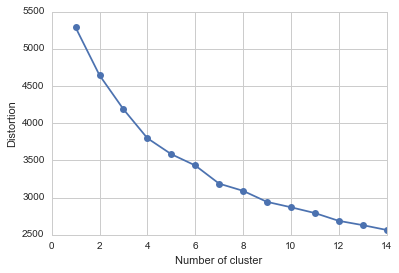

In [704]:
distortions = []
for i in range (1, 15):
    km = k_means = KMeans(init='k-means++', n_clusters=i, n_init=10).fit(X_pca)
    distortions.append(km.inertia_)
plt.plot(range(1, 15), distortions, marker='o')
plt.xlabel('Number of cluster')
plt.ylabel('Distortion')
plt.show()

#### Prendre 4 ou 5 cluster pour les parrains

In [716]:
parrain["cluster"] = k_means.labels_
parrain["pca_1"] =  X_pca[:,0]
parrain["pca_2"] =  X_pca[:,1]
parrain["pca_3"] =  X_pca[:,2]

In [717]:
k_means_labels = k_means.labels_
k_means_cluster_centers = k_means.cluster_centers_
k_means_labels_unique = np.unique(k_means_labels)

In [718]:
dico_color = {0: '#4169e1',
              1: '#4169e1',
              2: '#00ff7f',
              3: '#77dfc9',
              4: '#c2cc4a',
              5: '#ff8c00',
              6: '#ff6d00',
              7: '#ff4500',
              8: '#f1ae50',
              9: '#ffa500'
              }
#'#4169e1','#4169e1','#00ff7f','#c2cc4a','#ff8c00','#ff6d00','#ff4500'

center_color = [col for col in dico_color.values()]

color = [col for col in dico_color.values()]
parrain["color"] = parrain.cluster.map(dico_color)

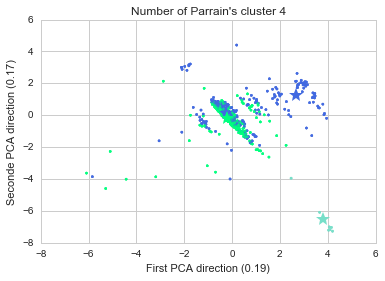

In [719]:
for k, col in zip(range(k_means_labels_unique.argmax() + 1), color):
    my_members = k_means_labels == k
    cluster_center = k_means_cluster_centers[k]
    plt.scatter(parrain.pca_1, parrain.pca_2, color=parrain.color,
             marker='.', alpha=0.6)
    plt.plot(cluster_center[0], cluster_center[1], 
         '*', markerfacecolor=col, markersize=15)
                     
plt.title("Number of Parrain's cluster %d" % k_means.n_clusters)
plt.xlabel('First PCA direction (%s)' % round(pca.explained_variance_ratio_[0], 2))
plt.ylabel('Seconde PCA direction (%s)' % round(pca.explained_variance_ratio_[1], 2))

In [720]:
parrain.cluster.value_counts()

2    511
1    380
0     64
3      7
Name: cluster, dtype: int64

In [721]:
parrain['target'] = data.target

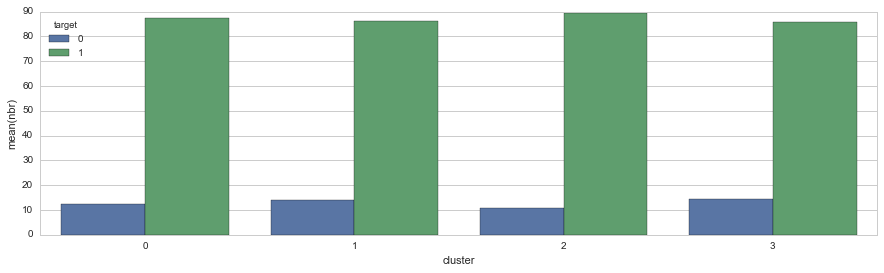

In [722]:
col_target("cluster", parrain)

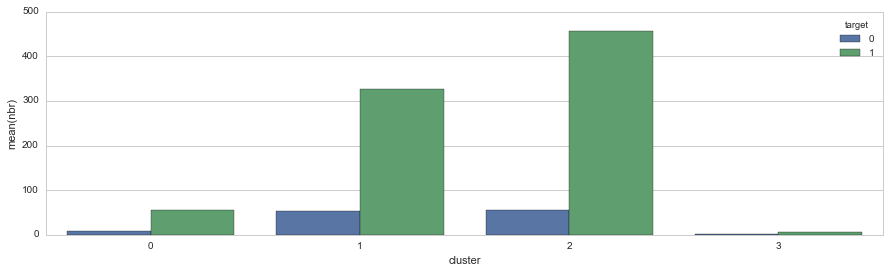

In [723]:
col_target_q("cluster", parrain)

In [725]:
data[features_p].head()

,H/F,group_formation_p,Niveau_diplome_num,Code formation_p,age_p,Secteur d'activité,Fonction actuelle,A déjà eu un parrainage annulé ?,Temporairement indisponible
0,F,ecole,5,3 : Commerce / Finance / Gestion,27.0,Conseil / Etudes,Consultant en stratégie,Non,Non
1,H,ecole,5,3 : Commerce / Finance / Gestion,25.0,Conseil / Etudes,Associé,Non,Non
2,F,ecole,4,3 : Commerce / Finance / Gestion,33.0,Autre,Responsable marketing,Non,Oui
3,F,ecole,6,3 : Commerce / Finance / Gestion,35.0,Communication / Médias,Consultant en communication,Non,Non
4,H,ecole,5,3 : Commerce / Finance / Gestion,39.0,Autre,Président,Non,Non


In [744]:
## Type de communes (Filleul)

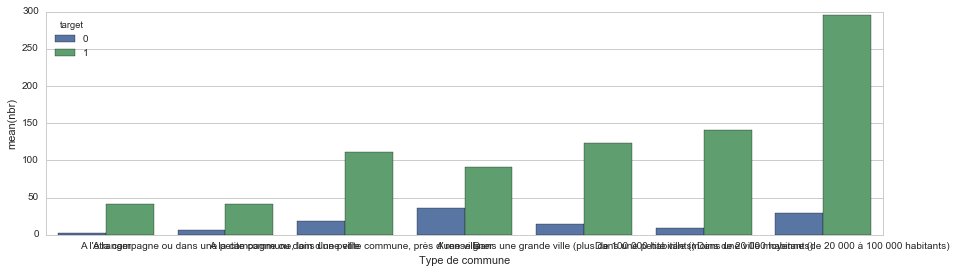

In [748]:
col_target_q("Type de commune", data)

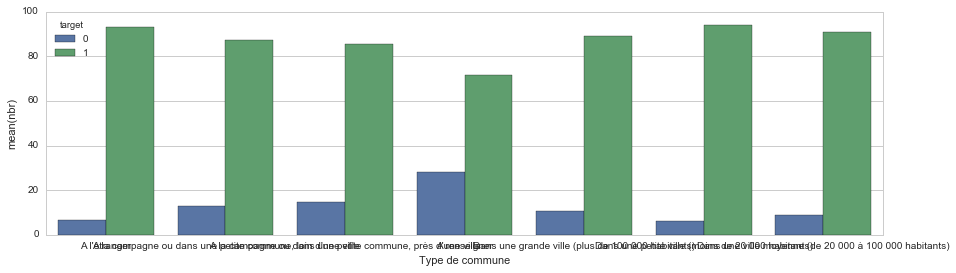

In [747]:
col_target("Type de commune", data)